# LLM with multiple tools

In [1]:
import os
from dotenv import load_dotenv

load_dotenv()

os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY')

In [4]:
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper

wiki = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper())


In [5]:
from langchain_community.tools import DuckDuckGoSearchRun

search = DuckDuckGoSearchRun()


In [14]:
from langchain.tools import BaseTool
from typing import Dict

class VibeAnalyzerTool(BaseTool):
    name: str = "vibe_analyzer"
    description: str = "Analyzes text vibe and returns emoji, summary, and confidence score"

    def _run(self, text: str) -> Dict:
        text_lower = text.lower()

        if any(w in text_lower for w in ["urgent", "asap", "immediately"]):
            vibe = "urgent"
            emoji = "🚨"
        elif any(w in text_lower for w in ["idea", "build", "create", "startup"]):
            vibe = "creative"
            emoji = "🚀"
        elif any(w in text_lower for w in ["error", "bug", "fail"]):
            vibe = "problem"
            emoji = "🐛"
        else:
            vibe = "neutral"
            emoji = "🧠"

        summary = text.split(".")[0][:80]
        confidence = round(min(len(text) / 100, 1.0), 2)

        return {
            "vibe": vibe,
            "emoji": emoji,
            "tldr": summary,
            "confidence": confidence
        }

    async def _arun(self, text: str):
        raise NotImplementedError()

vibe_tool = VibeAnalyzerTool()


In [16]:
tools = [wiki, search, vibe_tool]

In [25]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model = 'gpt-4o-mini')

llm_with_tools = llm.bind_tools(tools)

In [26]:
llm_with_tools

RunnableBinding(bound=ChatOpenAI(profile={'max_input_tokens': 128000, 'max_output_tokens': 16384, 'image_inputs': True, 'audio_inputs': False, 'video_inputs': False, 'image_outputs': False, 'audio_outputs': False, 'video_outputs': False, 'reasoning_output': False, 'tool_calling': True, 'structured_output': True, 'image_url_inputs': True, 'pdf_inputs': True, 'pdf_tool_message': True, 'image_tool_message': True, 'tool_choice': True}, client=<openai.resources.chat.completions.completions.Completions object at 0x117471590>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x117472c10>, root_client=<openai.OpenAI object at 0x1173e3d90>, root_async_client=<openai.AsyncOpenAI object at 0x117472990>, model_name='gpt-4o-mini', model_kwargs={}, openai_api_key=SecretStr('**********'), stream_usage=True), kwargs={'tools': [{'type': 'function', 'function': {'name': 'wikipedia', 'description': 'A wrapper around Wikipedia. Useful for when you need to answer gener

In [27]:
from langchain_core.messages import AIMessage, HumanMessage

llm_with_tools.invoke([HumanMessage(f"what is recent ai news ?")]).tool_calls

[{'name': 'duckduckgo_search',
  'args': {'query': 'recent AI news'},
  'id': 'call_rIjj0wCuQq6Mr6PvsmSZpmh5',
  'type': 'tool_call'}]

In [28]:
# state
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated
from langgraph.graph.message import add_messages


class ChatState(TypedDict):
    messages : Annotated[list[AnyMessage], add_messages]

In [42]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

def tool_calling_llm(state: ChatState):
    return {"messages" : [llm_with_tools.invoke(state['messages'])]}


# build graph
builder = StateGraph(ChatState)
builder.add_node('tool_calling_llm',tool_calling_llm)
builder.add_node('tools', ToolNode(tools))

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges("tool_calling_llm", tools_condition)

builder.add_edge("tools", END)


graph = builder.compile()

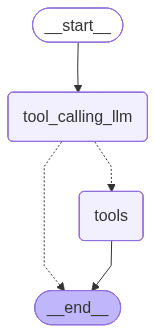

In [43]:
graph

In [47]:
graph.invoke({
    "messages": [HumanMessage(content='What is RAM?')]
})


/Users/nayanverma/learning/RAG/.venv/lib/python3.14/site-packages/wikipedia/wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /Users/nayanverma/learning/RAG/.venv/lib/python3.14/site-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


{'messages': [HumanMessage(content='What is RAM?', additional_kwargs={}, response_metadata={}, id='32466622-4243-4726-8640-582e4c007189'),
  AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 13, 'prompt_tokens': 165, 'total_tokens': 178, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_3683ee3deb', 'id': 'chatcmpl-Cttq2taK4GUlPXVrL7seE56pUa8do', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019b838e-9564-7e03-96cf-a0d0c70e3b8f-0', tool_calls=[{'name': 'wikipedia', 'args': {'query': 'RAM'}, 'id': 'call_ffpGaipu8WX6LiEo24dWUvsJ', 'type': 'tool_call'}], usage_metadata={'input_tokens': 165, 'output_tokens': 13, 'total_tokens': 178, 'inpu